In [1]:
# import all needed packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Read the dataset
# Set the seperator and the decimal point
df_cars = pd.read_csv('./final_dataset.csv', sep=',', decimal='.')

# Data type of each column of the dataset as some were objects
df_cars.convert_dtypes(infer_objects=False).dtypes

# Check for missing values and sum the result
df_cars.isna().sum()

2023-01-27 18:49:05.765156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


uuid                                0
Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [2]:
# 2. Number of rows and columns
rows = len(df_cars.axes[0])
columns = len(df_cars.axes[1])

In [14]:
# Min/Max/Mean value
df_cars['Engine Size(L)'].max()
df_cars['Engine Size(L)'].mean()
df_cars['Engine Size(L)'].min()

df_cars.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Engine Size(L),7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
Fuel Consumption City (L/100 km),7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
Fuel Consumption Hwy (L/100 km),7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
Fuel Consumption Comb (L/100 km),7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
Fuel Consumption Comb (mpg),7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
CO2 Emissions(g/km),7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


In [4]:
# Removing (even there a none) all dataset that a null
dataset = df_cars.dropna()

# Setting the index to the uuid
dataset = dataset.set_index('uuid')

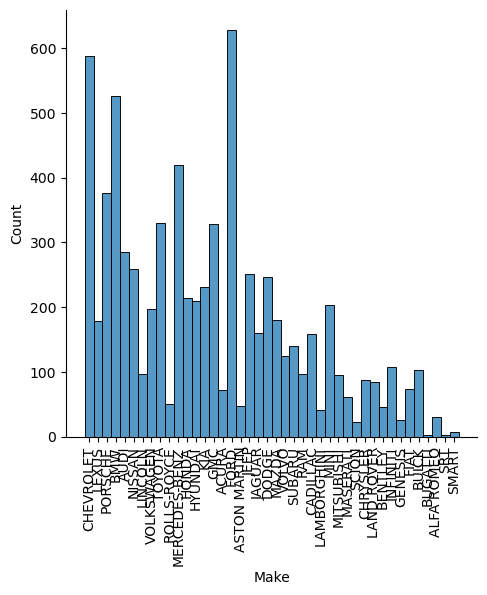

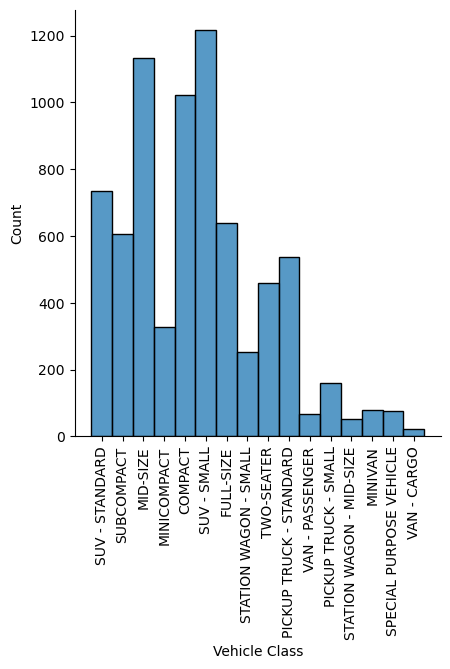

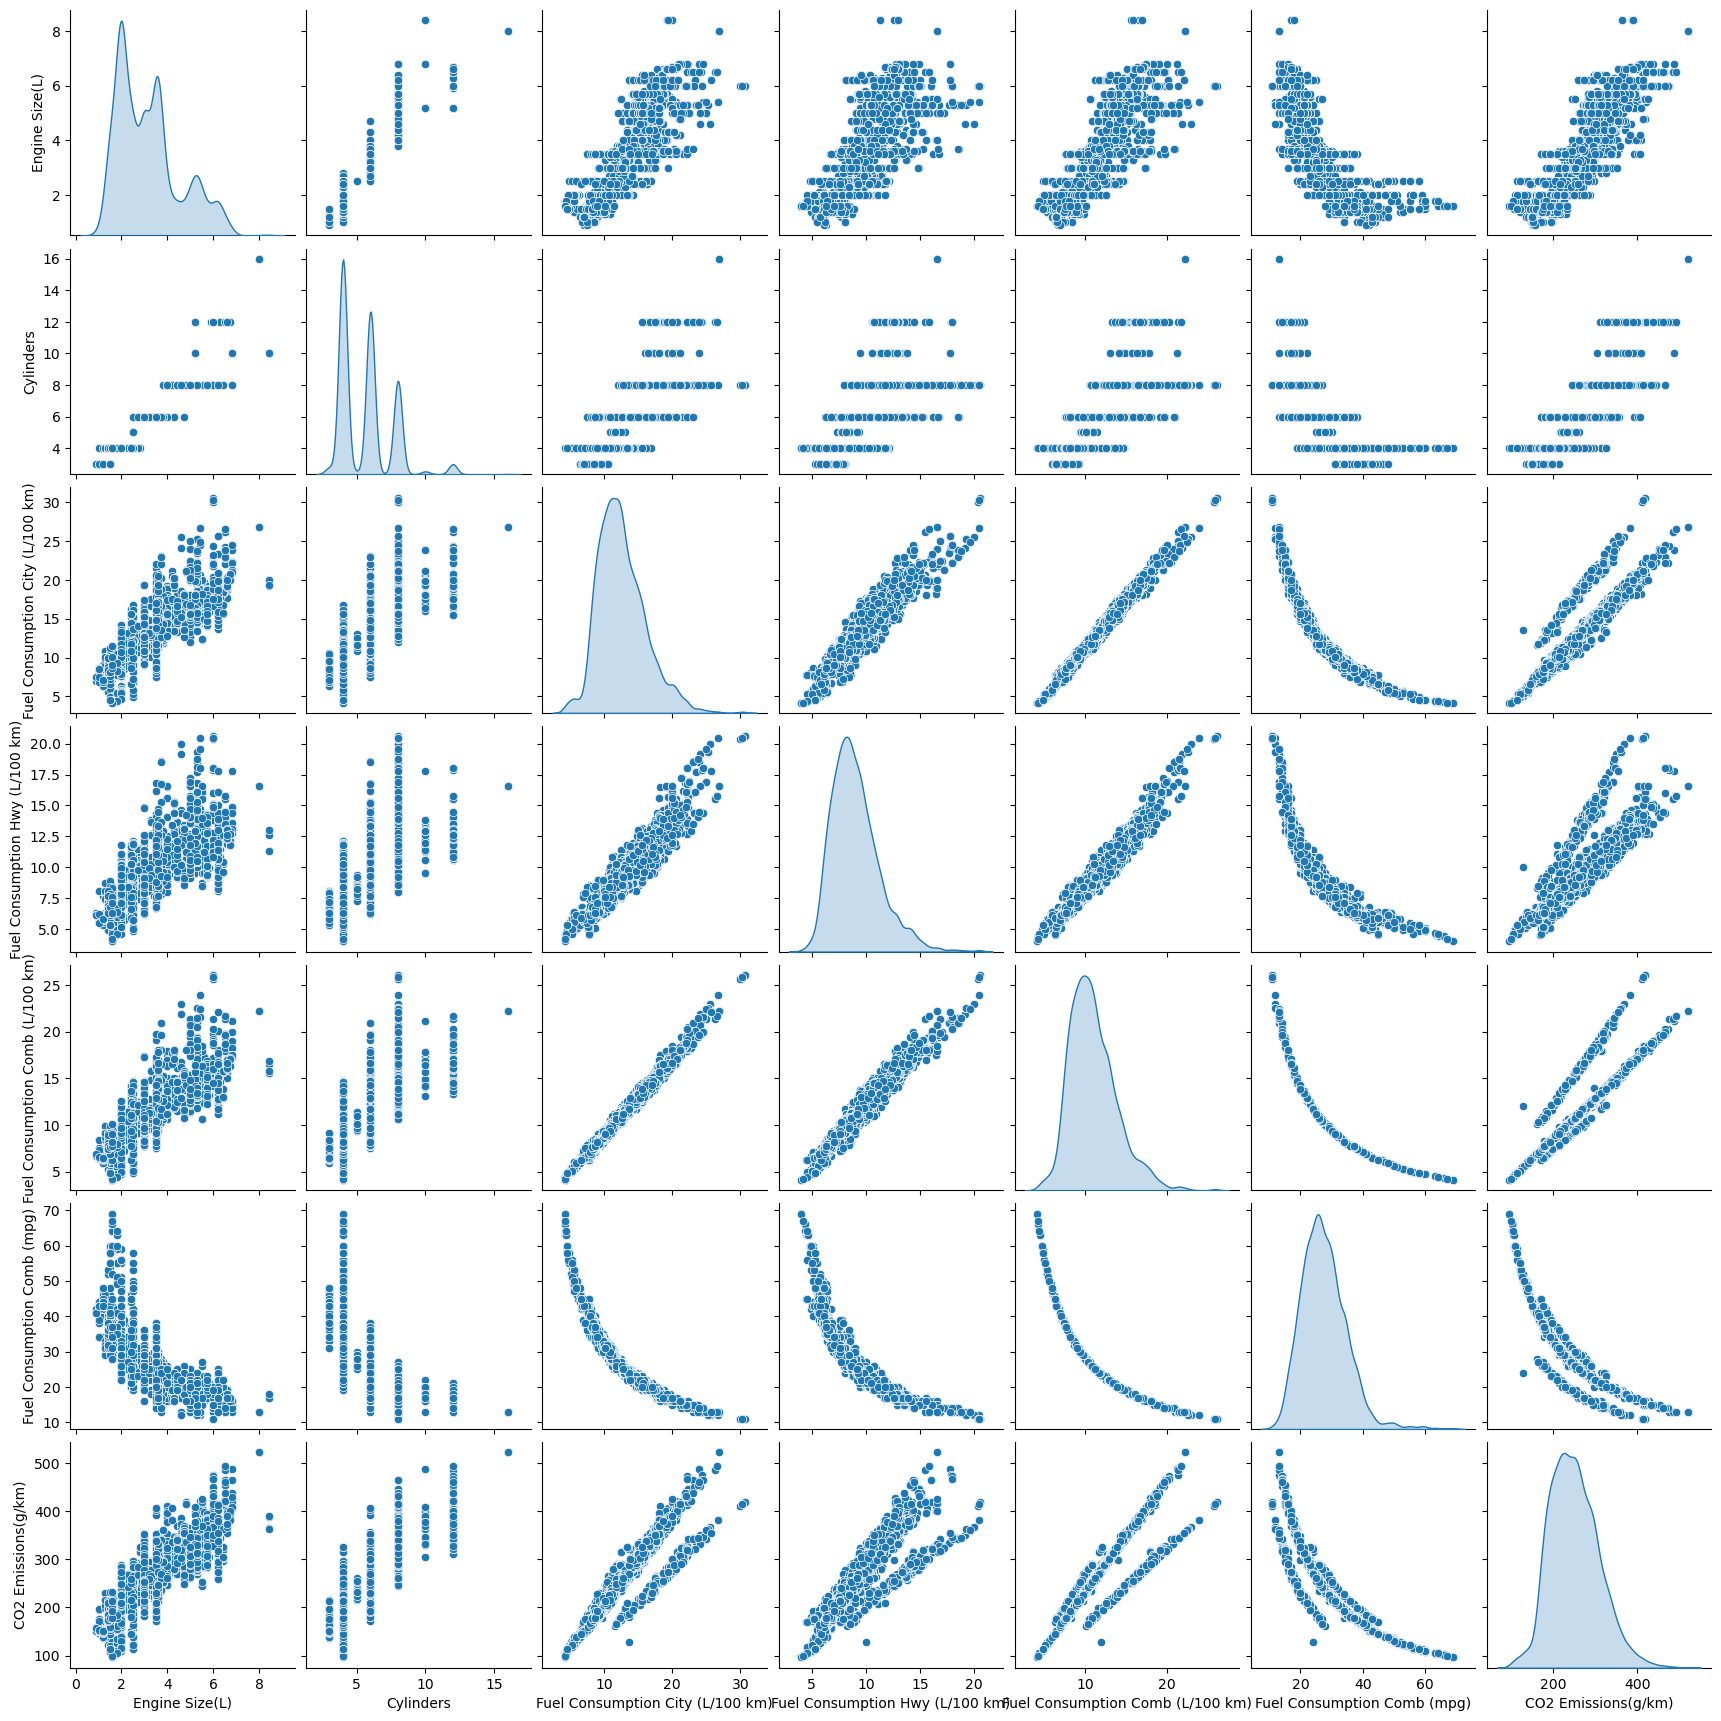

In [5]:
# Exploring the dataset 

# Which makes are in there
# Why do I do this? - Maybe the dataset is not balanced towards different makes
LModel_make_unique = dataset['Make'].unique()
# How many different have we
iModel_make_unique = len(LModel_make_unique)
# How many are there of a make 
# What we can see in the plot is that the most cars are from ford, followed by chevrolet and BMW.
dPlot_make = sns.displot(dataset, x="Make")
dPlot_make.ax.tick_params(axis='x', rotation=90)


# How many vehicle classes are there?
# Why do I do this? - Maybe the dataset is not balanced towards different vehicle classes
LModel_v_class_unique = dataset['Vehicle Class'].unique()
# Histogram with the how many we have from a class 
# What we can see in the plot is that the most cars are from SUV, followed by small car and midsize car.
dPlot_v_class = sns.displot(dataset, x="Vehicle Class")
dPlot_v_class.ax.tick_params(axis='x', rotation=90)

# Pairplot data
# Why do I do this? - Maybe there are some correlations between the features
sns.pairplot(dataset, diag_kind='kde')

First example: [[ 2.   4.  10.2  8.5  9.4 30. ]]

Normalized: [[-0.87 -0.9  -0.7  -0.27 -0.57  0.39]]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
1/1 [==============================] - 0s 39ms/step


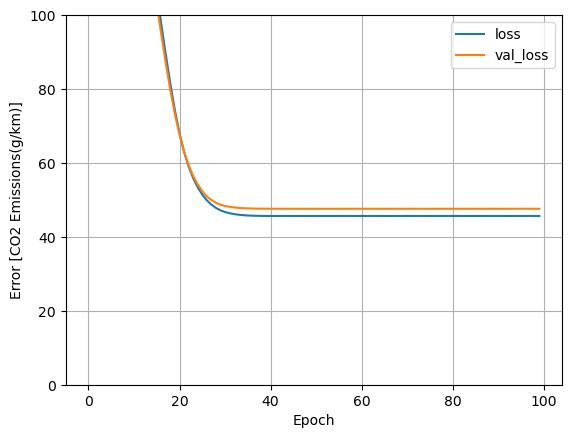

In [38]:
# Choosing the subset of the data I would like to focus on and only choosing the numerical data
dataset_num = dataset[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)']]

# Making reusable variables to use parts of the data
fuel_consumption_100 = 'Fuel Consumption Comb (L/100 km)'
co2_emissions = 'CO2 Emissions(g/km)'

# -----------------------------------
# Split dataset into train and test dataset
# -----------------------------------

# Taking half of the dataset to train it 
train_dataset = dataset_num.sample(frac=0.5, random_state=0)
# Taking the other half to test it
test_dataset = dataset_num.drop(train_dataset.index)

# -----------------------------------
# Split features from labels 
# -----------------------------------

# Copying the dataset to not change the original
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Removing the labels from the features
train_labels = test_features.pop(co2_emissions)
test_labels = train_features.pop(co2_emissions)

# Adding a normalizer
normalizer = layers.Normalization(axis=-1)

# Fitting the normalizer to the data
# Why do we need a normalizer? - The normalizer is used to normalize the data to a mean of 0 and a standard deviation of 1.
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:1])

# comparing the normalized data with the normal data
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

# -----------------------------------
# Linear regression
# -----------------------------------  

# Creating the data for the emission normalization 
emission = np.array(dataset[fuel_consumption_100])
# Normalizing the data 
emission_normalizer = layers.Normalization(input_shape=[1,], axis=None) 
emission_normalizer.adapt(emission)

# Creating the emission model which should predict the emission of a car
emission_model = tf.keras.Sequential([
    emission_normalizer,
    layers.Dense(units=1)
])

# Showing a summary of the model
emission_model.summary()

# Compiling the model
emission_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error")

# Predict a value for testing
emission_model.predict(emission[:10])

history = emission_model.fit(
    train_features[fuel_consumption_100],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

# Creating a dataframe to use it for analysing the performance of the model
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

# Plotting the performance of the model
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [CO2 Emissions(g/km)]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

16/16 [==============================] - 0s 582us/step


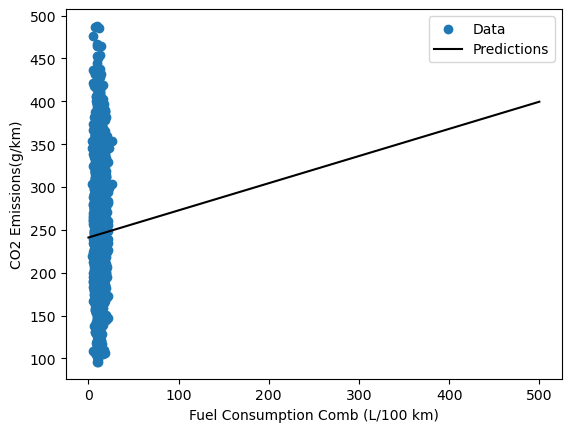

In [39]:
# Creating x and y for the graph represantation of the model
x = tf.linspace(0.0, 500, 500)
y = emission_model.predict(x)

train_features[fuel_consumption_100].size

# Creating the graph
def plot_emission(x, y):
  plt.scatter(train_features[fuel_consumption_100],train_labels.sample(3692), label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel(fuel_consumption_100)
  plt.ylabel(co2_emissions)
  plt.legend()


plot_emission(x,y)

# The graph is somehow not how I expected it to be. The data should flow around the predictions. 